got help from Jordan Vani and Danny Fay

In [112]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as pl
import matplotlib.pylab as plt
from geopandas import GeoDataFrame
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn import linear_model
%matplotlib inline

# Downloading MTA Ridership Data

In [54]:
rides = np.load("MTA_Fare.npy")
rides

array([[[56961, 64703, 68002, ..., 36527, 33929, 36824],
        [ 1732,  2083,  2107, ...,  1264,  1172,  1238],
        [  203,   276,   245, ...,   186,   167,   167],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [   -1,    -1,    -1, ...,  1121,  1377,   712]],

       [[16210, 20179, 21769, ...,    -1,    -1,    -1],
        [  503,   647,   665, ...,    -1,    -1,    -1],
        [   41,    43,    44, ...,    -1,    -1,    -1],
        ..., 
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [   -1,    -1,    -1, ...,    -1,    -1,    -1]],

       [[ 3292,  3429,  3629, ...,  3746,  3406,  3217],
        [  110,    92,   102, ...,   212,   209,   211],
        [    7,     6,    13, ...,    26,    20,    22],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0, 

In [23]:
np.mean(rides)

2157.8262034961899

In [24]:
rides.shape

(600, 23, 194)

600 stations, 23 card types, 194 weeks?

# replacing -1 with NaN

In [33]:
# trying a method found online, not working
# def replaceNoData(rides, :
    # for n, i in enumerate(array):
        # if i == -1:
            # scanBlock[n] = np.nan

In [42]:
# Jordan's method
data = np.empty(rides.shape, dtype='float')

for index, arr in enumerate(rides):
    data[index] = arr.astype('float')
    
for arr in data:
    arr[arr == -1] = np.nan

In [40]:
data

In [43]:
np.nanmean(data)

2849.4162786534275

In [46]:
np.nanmedian(data)

31.0

# Task 1: Detecting Major Event

In [49]:
# Finding number of riders per week
card_types = np.nansum(data, axis=1)
weekly_rides = np.nansum(card_types, axis=0)

In [50]:
# should be equal to number of weeks
len(weekly_rides)

194

In [51]:
# max occurs in week 176
np.where(weekly_rides == max(weekly_rides))

(array([176]),)

In [52]:
# min occurs in week 126
np.where(weekly_rides == min(weekly_rides))

(array([126]),)

need to figure out what these real dates are

start date is 05/21/2010 - taking a method from Jordan for how to calculate from there

In [56]:
# calculating date of max event

def eventdate(numberofweeks):
    """Calculates new date from startdate given weeks.
    Arguments:
    deltaweek - how many weeks since startdate (int)
    """
    startdate = dt.datetime.strptime('05/21/2010', '%m/%d/%Y')
    dweek = dt.timedelta(weeks=numberofweeks)
    return (startdate + dweek).date()
    
print eventdate(176)

2013-10-04


first page of Google results shows no major events in NYC on October 4, 2013 other than Twitter's IPO

In [59]:
# now calculating date of min event

print eventdate(126)

2012-10-19


In [60]:
# didn't find anything for this date, then saw that Jordan had gotten a different result for the min
# (126 weeks, to 2012-10-26), so I'm going with his date. Google search quickly finds that Hurricane Sandy hit NYC
# EDIT LATER: realized I didn't account for the 0th value, so 127 made sense after the function above output 126

print eventdate(127)

2012-10-26


trying the boxplot shown in the lab

AttributeError: 'numpy.ndarray' object has no attribute 'boxplot'

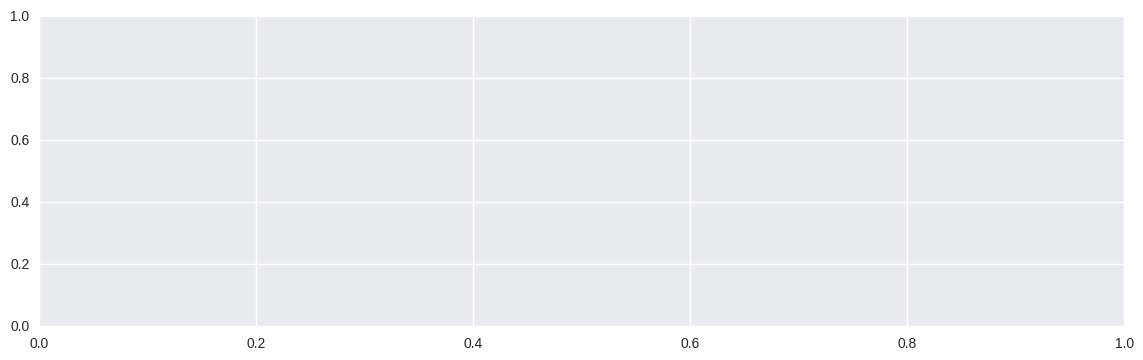

In [77]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
#wr_copy=weekly_rides.copy()
#wr_copy.index=wr_copy.index.strftime("%B %Y")
weekly_rides.boxplot(figsize=(15,7),ax=ax,rot=90);
#ax.set_ylim([-200,16000])

not working, so moving on to Jordan's method

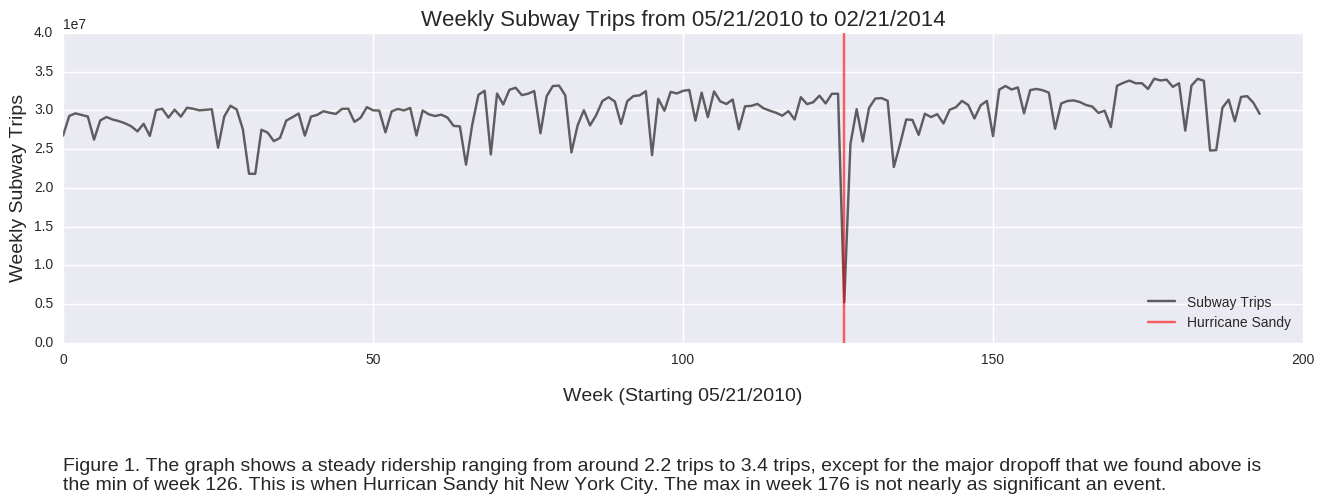

In [83]:
# plotting all weekly trips data, with vertical line at location 126, when Hurricane Sandy hit

fig, (ax) = pl.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax.plot(range(weekly_rides.shape[0]), weekly_rides, c='k', 
        alpha=0.6, label="Subway Trips")
ax.plot([126, 126], [0, 40000000], c='r',
        alpha=0.6, label="Hurricane Sandy")
ax.set_xlabel('Week (Starting 05/21/2010)', fontsize=14, labelpad=15)
ax.set_ylabel('Weekly Subway Trips', fontsize=14)
ax.set_title('Weekly Subway Trips from 05/21/2010 to 02/21/2014', fontsize=16)
ax.text(0, -19000000, "Figure 1. The graph shows a steady ridership ranging from around 2.2 trips to 3.4 trips, \
except for the major dropoff that we found above is \nthe min of week 126. This is when Hurrican Sandy hit\
 New York City. The max in week 176 is not nearly as significant an event.", fontsize=14)
ax.legend(loc='lower right', ncol=1)

# Task 2: Finding Changes

Instructions: Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. By how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [95]:
# need to isolate how many summed trips there are per card type

stations = np.nansum(data, axis=0)
week_stations = np.nansum(stations, axis=2)

len(week_stations)

Hm that didn't work. Thought stations was axis 0, card types was axis 1, and weeks was axis 2.

In [89]:
stations.shape

(23, 194)

Instead doing what Jordan did with logarithmic plot.

In [94]:
# transposing rows and columns
# now it's card types in the columns and weeks in the rows
cardtype = pd.DataFrame(stations)
cardtype_T = cardtype.T
cardtype_T.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
1,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0
3,12653675.0,562602.0,52063.0,196389.0,37429.0,4032753.0,9450081.0,11221.0,305513.0,606270.0,...,147094.0,902549.0,68099.0,32404.0,0.0,122051.0,21630.0,6590.0,484.0,0.0
4,12809694.0,548858.0,51153.0,194883.0,35210.0,3925446.0,9294002.0,10515.0,335780.0,563446.0,...,137888.0,855573.0,66377.0,31933.0,176.0,119776.0,20297.0,6313.0,452.0,0.0


In [96]:
len(cardtype_T)

194

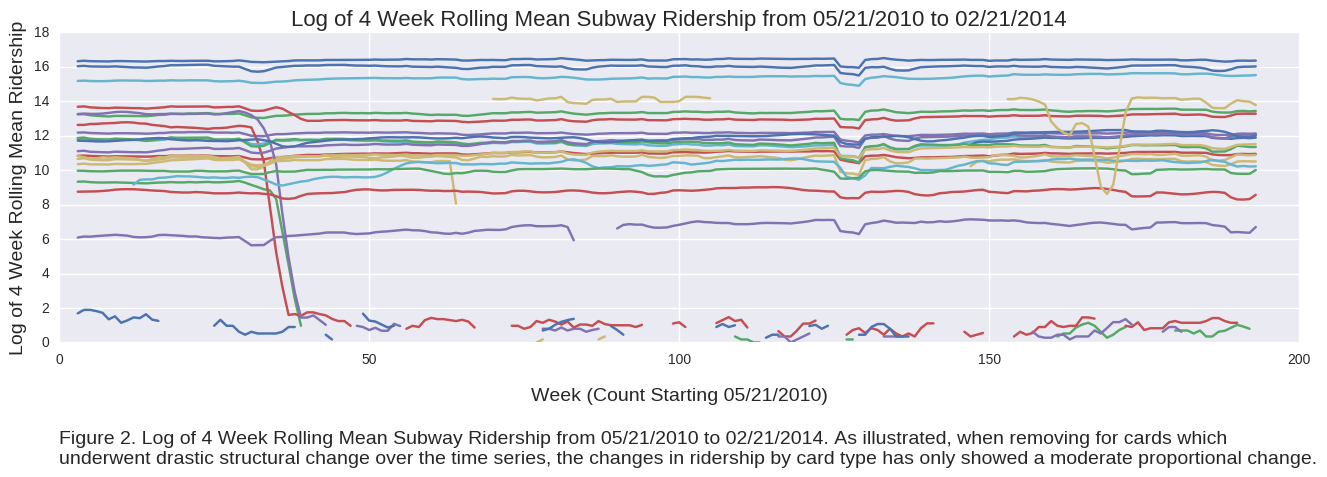

In [102]:
fig, (ax) = pl.subplots(nrows=1, ncols=1, figsize=(16, 4))

for x in cardtype_T:
    #if x not in exc_cards:
        ax.plot(range(194),
                np.log(cardtype_T[x]).rolling(window=4, center=False).mean())
ax.set_xlabel('Week (Count Starting 05/21/2010)', fontsize=14, labelpad=15)
ax.set_ylabel('Log of 4 Week Rolling Mean Ridership', fontsize=14)
ax.set_title('Log of 4 Week Rolling Mean Subway Ridership from 05/21/2010 \
to 02/21/2014', fontsize=16)
ax.text(0, -7, "Figure 2. Log of 4 Week Rolling Mean Subway Ridership \
from 05/21/2010 to 02/21/2014. As illustrated, when removing for cards \
which \nunderwent drastic structural change over the time series, the \
changes in ridership by card type has only showed a moderate proportional \
change.", fontsize=14)

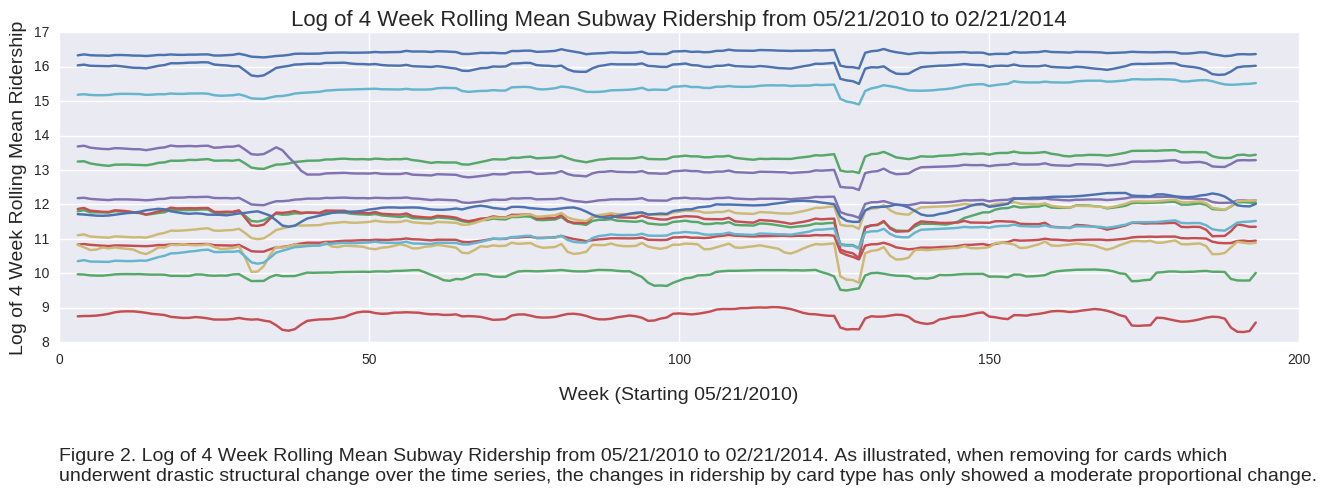

In [107]:
# now same as above, but removing 0 values

no_cards = []
[no_cards.append(x) for x in cardtype_T.columns for i in cardtype_T[x] if i < 1 if x not in no_cards]

fig, (ax) = pl.subplots(nrows=1, ncols=1, figsize=(16, 4))

for x in cardtype_T:
    if x not in no_cards:
        ax.plot(range(194),
                np.log(cardtype_T[x]).rolling(window=4, center=False).mean())
ax.set_xlabel('Week (Starting 05/21/2010)', fontsize=14, labelpad=15)
ax.set_ylabel('Log of 4 Week Rolling Mean Ridership', fontsize=14)
ax.set_title('Log of 4 Week Rolling Mean Subway Ridership from 05/21/2010 \
to 02/21/2014', fontsize=16)
ax.text(0, 4, "Figure 2. As illustrated, when removing for cards \
which \nunderwent drastic structural change over the time series, the \
changes in ridership by card type has only showed a moderate proportional \
change.", fontsize=14)

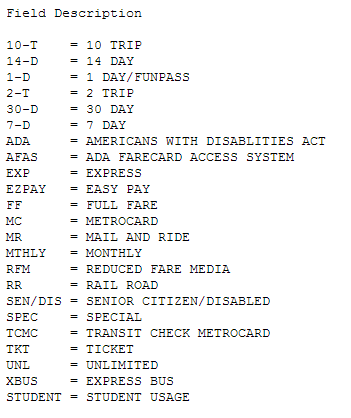

In [108]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

now taking a cue from Danny about plotting each card type's ridership data and fitting a line to it

In [116]:
# for each card type, plotting its ridership over time (per week), and fitting a linear model to it

ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

lr = linear_model.LinearRegression()
rm_card = pd.rolling_mean(cardtype_T, 10)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()


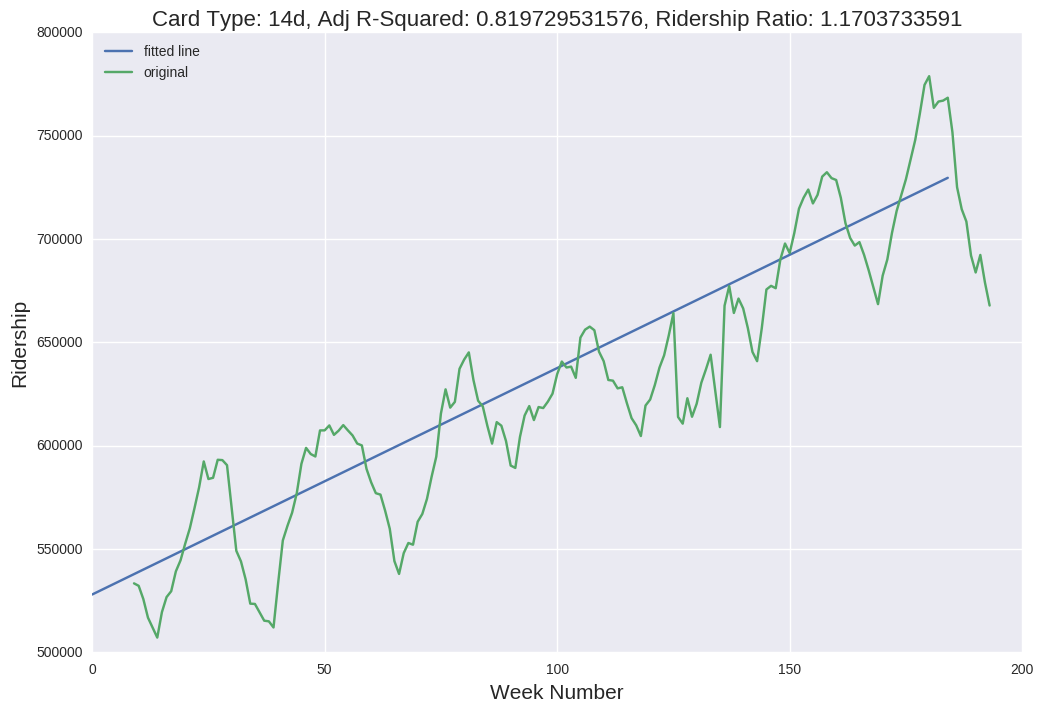

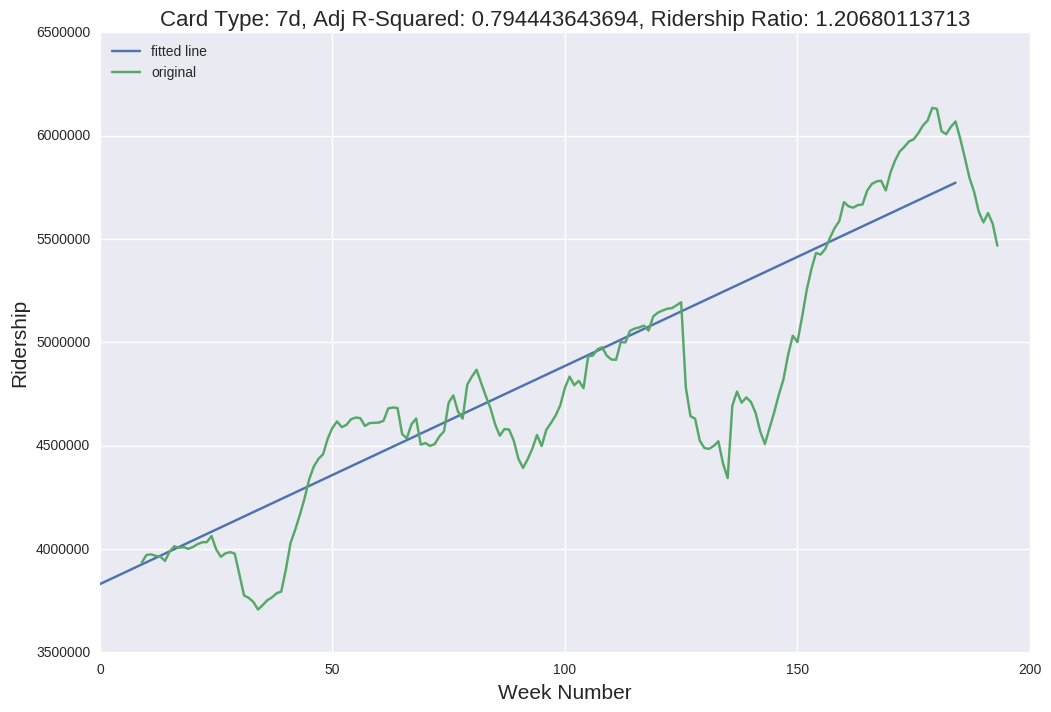

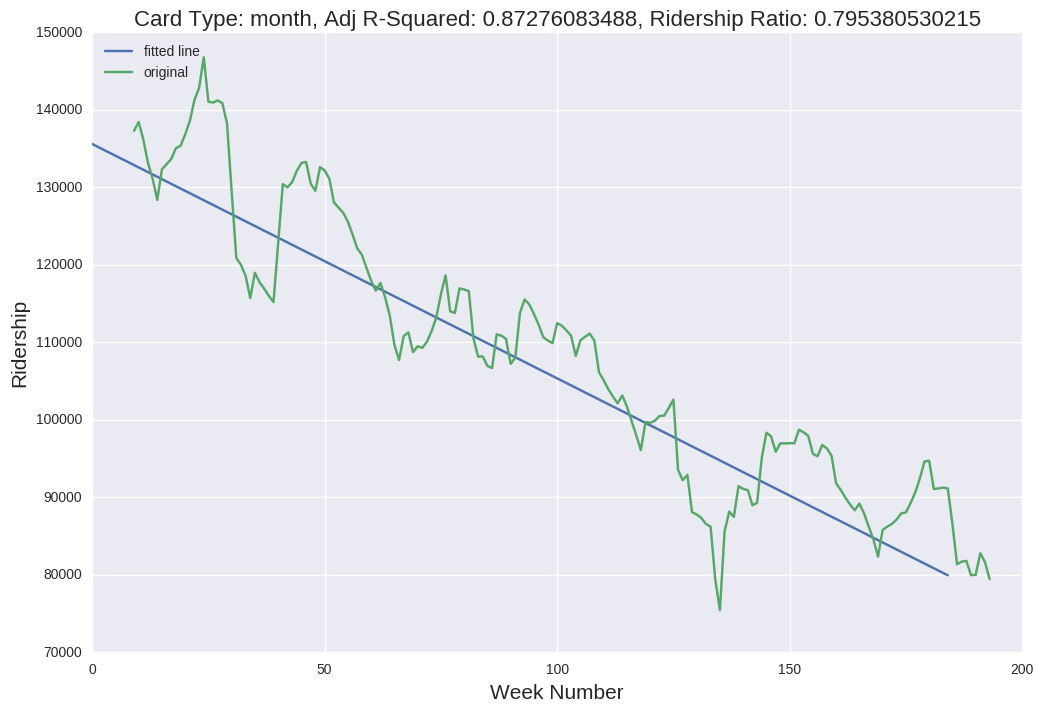

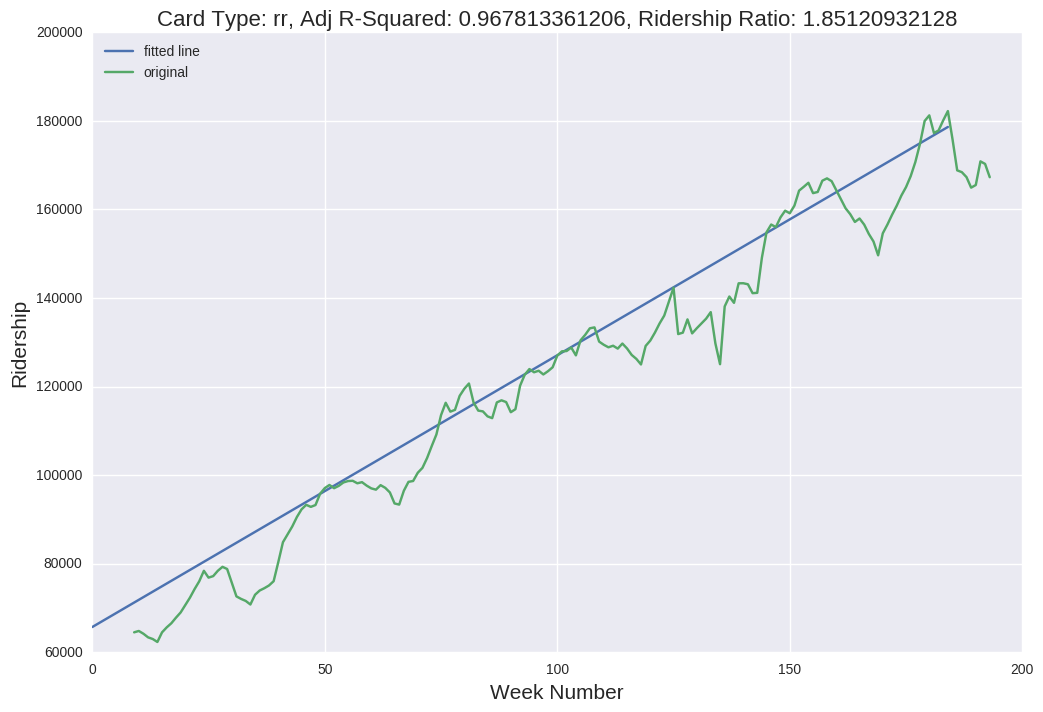

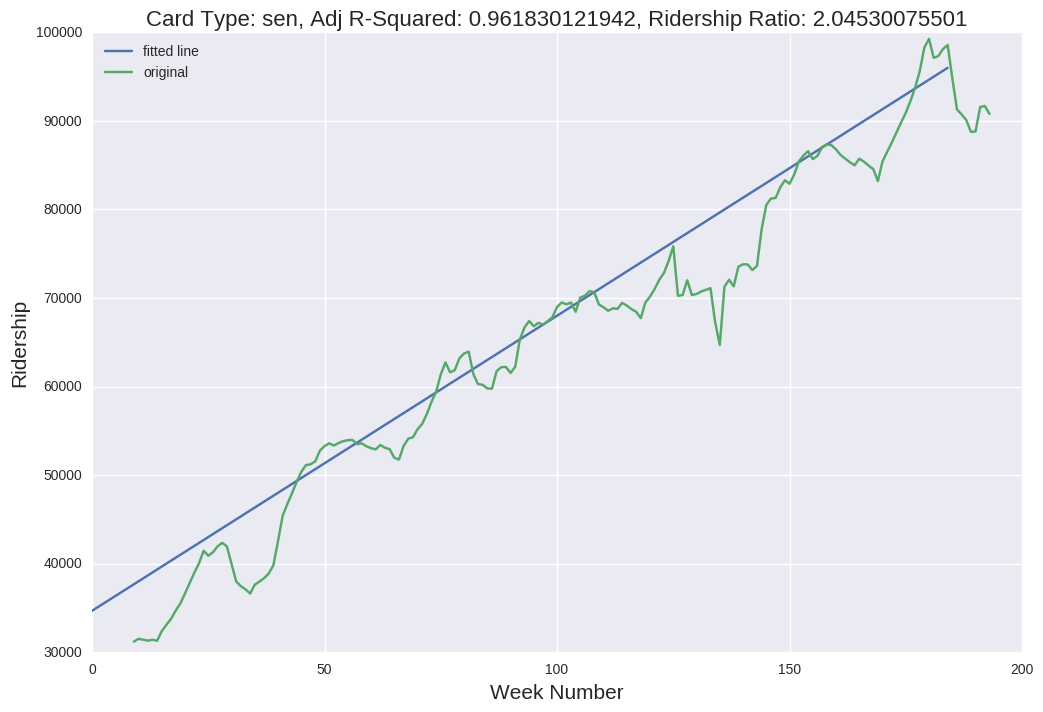

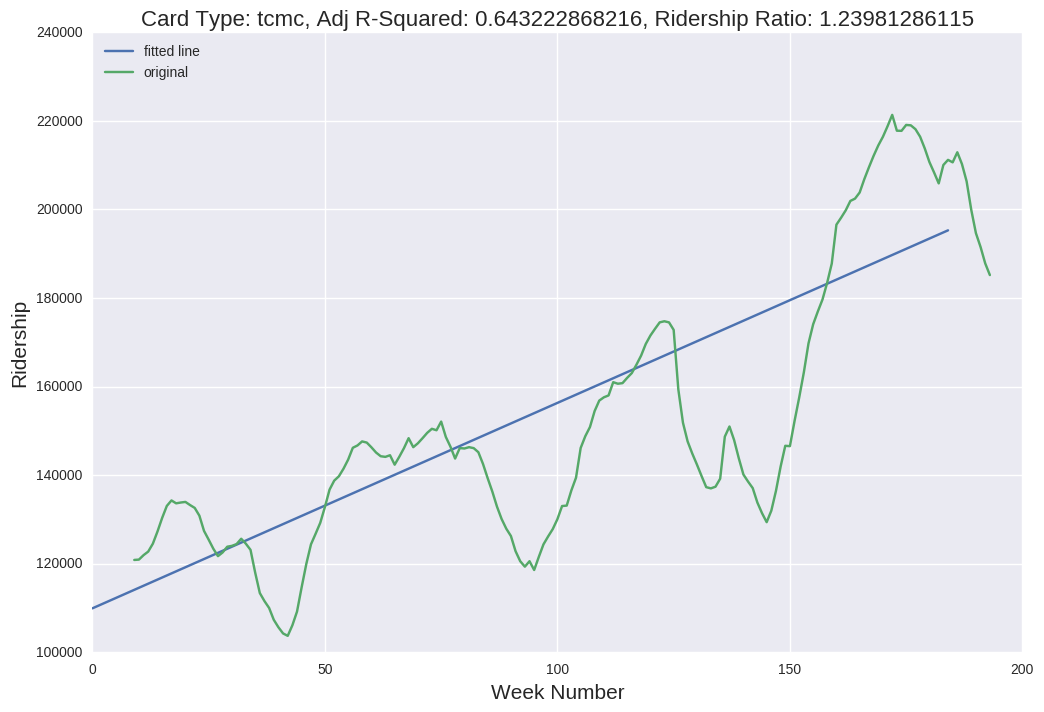

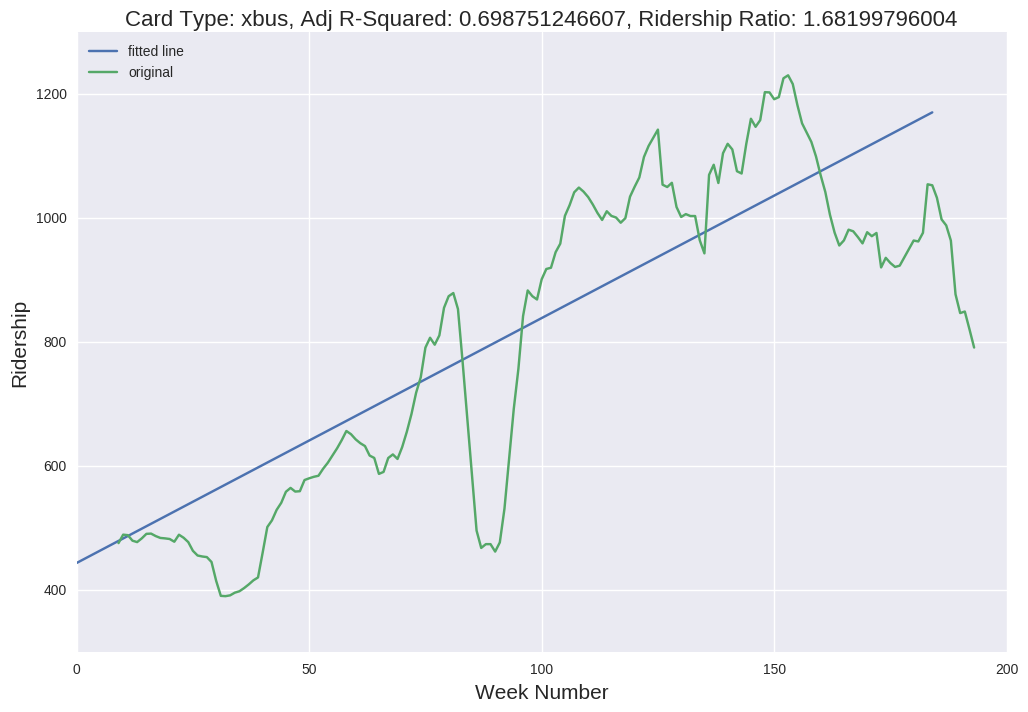

In [115]:
for column in rm_card:
    df = pd.DataFrame(rm_card[column]).reset_index()
    df.columns = ['week', 'rides']
    res = smf.ols(formula='rides ~ week', data=df).fit()
    avg_beg = np.nanmean(rm_card[column][:10])
    avg_end = np.nanmean(rm_card[column][:-10])
    # calculating change from start to finish
    ridership_ratio = avg_end / avg_beg
    # limiting the plots to card types with at least 5% change over the daterange
    if (res.rsquared_adj > .6) & (ridership_ratio > 1.05 or ridership_ratio < .95):
        plt.figure(figsize = (12,8))
        plt.plot(res.predict(), label='fitted line')
        plt.title("Card Type: %s, Adj R-Squared: %s, Ridership Ratio: %s"%(ridetype[column],
                                                                           res.rsquared_adj, ridership_ratio), fontsize=16)
        plt.xlabel("Week Number", fontsize=15)
        plt.ylabel("Ridership", fontsize=15)
        plt.plot(rm_card[column], label="original")
        plt.legend(loc=2)

14-day passes (17%), 7-day passes (21%), railroad passes (85%), senior passes (105%), transitcheck metrocard (24%), and express bus (68%) show clear growth; monthly pass went down in ridership (20%)